In [1]:
# Configurations

# input file
input_file = "./outputs/Mexico_wosis_merged.csv"
# year range [start, end]
year_range = [1970, 2020]
# snapshot year range [start, end]
snapshot_year_range = [2000, 2005]
# target column
target_column = 'orgc_value'
# feature columns
feature_columns = ['clay_value', 'phaq_value', 'sand_value', 'silt_value', 'tceq_value']
# training year range [start, end]
training_year_range = [1970, 2005]
# prediction year range [start, end]
prediction_year_range = [2005, 2020]


#---------- DO NOT EDIT BELOW THIS LINE ----------

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# ignore warnings
import warnings
warnings.filterwarnings("ignore")


TypeError: Descriptors cannot be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

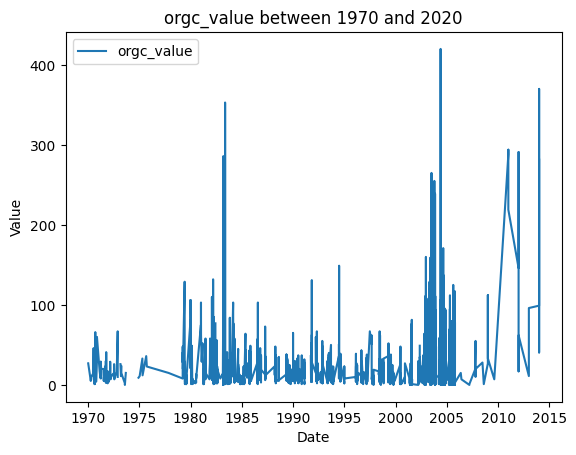

In [414]:
df = pd.read_csv(input_file)

df = df[feature_columns + [target_column] + ['date']].copy()

# convert date to datetime
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')
# set date as index
df.set_index('date', inplace=True)

# filter by year range  
df = df[(df.index.year >= year_range[0]) & (df.index.year <= year_range[1])]

# plot both values in different colors
plt.plot(df.index, df[target_column], label=target_column)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title(f'{target_column} between {year_range[0]} and {year_range[1]}')
plt.legend()
plt.show()

In [415]:
# # plot missing values
# df.isna().sum().plot(kind='bar')
# plt.title('Missing values')
# plt.show()

# replace missing values with the mean of the column
df[feature_columns] = df[feature_columns].fillna(df[feature_columns].mean())
df[target_column] = df[target_column].fillna(df[target_column].mean())

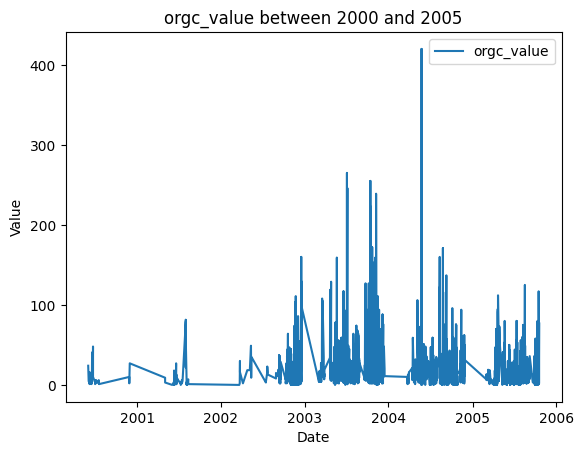

In [416]:
# snapshot of the data between 2000 and 2005
df_snapshot = df[(df.index.year >= snapshot_year_range[0]) & (df.index.year <= snapshot_year_range[1])]
# plot both values in different colors
plt.plot(df_snapshot.index, df_snapshot[target_column], label=target_column)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title(f'{target_column} between {snapshot_year_range[0]} and {snapshot_year_range[1]}')
plt.legend()
plt.show()

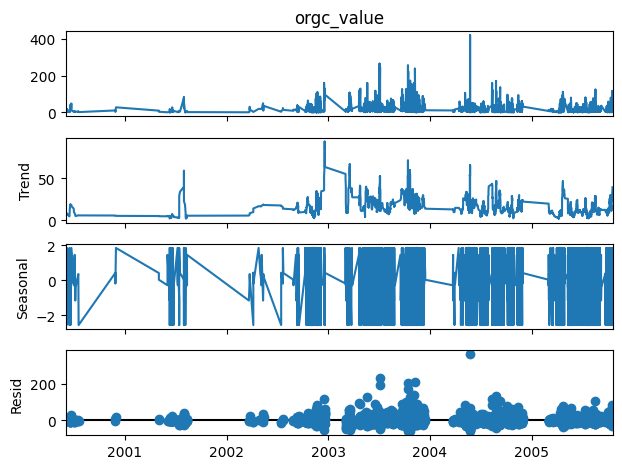

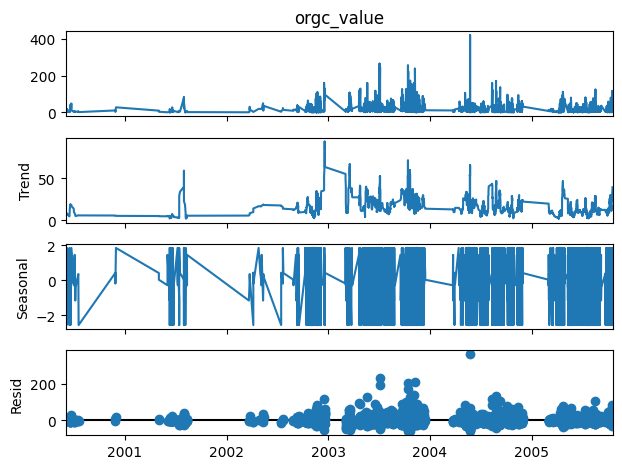

In [417]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_snapshot[target_column], period=12)
result.plot()

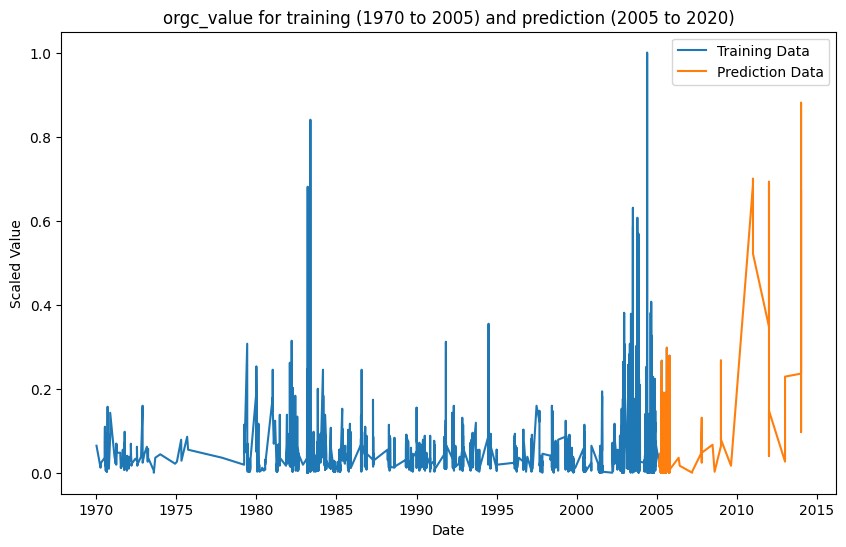

In [418]:
# training data
df_train = df[(df.index.year >= training_year_range[0]) & (df.index.year <= training_year_range[1])].copy()
# prediction data  
df_test = df[(df.index.year >= prediction_year_range[0]) & (df.index.year <= prediction_year_range[1])].copy()

# Create separate scalers for features and target
scaler = MinMaxScaler()

# Scale features
df_train[feature_columns] = scaler.fit_transform(df_train[feature_columns])
df_test[feature_columns] = scaler.transform(df_test[feature_columns])

# Scale target column 
df_train[target_column] = scaler.fit_transform(df_train[[target_column]])
df_test[target_column] = scaler.transform(df_test[[target_column]])

# plot the data
plt.figure(figsize=(10,6))
plt.plot(df_train.index, df_train[target_column], label='Training Data')
plt.plot(df_test.index, df_test[target_column], label='Prediction Data')
plt.xlabel('Date')
plt.ylabel('Scaled Value')
plt.title(f'{target_column} for training ({training_year_range[0]} to {training_year_range[1]}) and prediction ({prediction_year_range[0]} to {prediction_year_range[1]})')
plt.legend()
plt.show()

In [419]:
df_train.head()

,clay_value,phaq_value,sand_value,silt_value,tceq_value,orgc_value
date,,,,,,
1970-01-08,0.227273,0.466667,0.489796,0.344828,0.000000,0.064286
1970-04-10,0.136364,0.680000,0.632653,0.275862,0.057824,0.011905
1970-04-22,0.204545,0.773333,0.510204,0.344828,0.057824,0.023810
1970-07-15,0.215909,0.613333,0.540816,0.298851,0.057824,0.035714
1970-07-15,0.238636,0.706667,0.459184,0.367816,0.057824,0.071429


In [420]:
df_test.head()

,clay_value,phaq_value,sand_value,silt_value,tceq_value,orgc_value
date,,,,,,
2005-03-02,0.420455,0.733333,0.387755,0.264368,0.046000,0.016667
2005-03-02,0.295455,0.680000,0.510204,0.252874,0.057824,0.030952
2005-03-02,0.056818,0.746667,0.448980,0.563218,0.037000,0.030952
2005-03-03,0.045455,0.640000,0.897959,0.068966,0.057824,0.014286
2005-03-03,0.045455,0.653333,0.877551,0.091954,0.057824,0.014286


In [421]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# create a timeseries generator
n_length = 3  # sequence length
n_features = len(feature_columns)
batch_size = 32 # batch size

# Helper function to create sequences
def create_sequences(data, target, n_length):
    X, y = [], []
    for i in range(len(data) - n_length):
        X.append(data[i:i + n_length])
        y.append(target[i + n_length])
    return np.array(X), np.array(y)

# Reshape training and test data
X_train, y_train = create_sequences(df_train[feature_columns].values, df_train[target_column].values, n_length)
X_test, y_test = create_sequences(df_test[feature_columns].values, df_test[target_column].values, n_length)

print('X_train.shape', X_train.shape, 'y_train.shape', y_train.shape)
print('X_test.shape', X_test.shape, 'y_test.shape', y_test.shape)



X_train.shape (5141, 3, 5) y_train.shape (5141,)
X_test.shape (1007, 3, 5) y_test.shape (1007,)


In [422]:
def create_model(optimizer='adam', dropout_rate=0.2, lstm_units=50):
    model = Sequential()
    model.add(LSTM(lstm_units, activation='relu', input_shape=(n_length, n_features), 
                  return_sequences=True, recurrent_dropout=0.1))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units//2, activation='relu', recurrent_dropout=0.1))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse'])
    return model

# Define callbacks with more patience
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.pkl', monitor='val_loss', save_best_only=True)

# Define and compile the model
model = create_model(optimizer='adam', dropout_rate=0.2, lstm_units=64)  # Reduced units and dropout

# Split training data into train and validation sets
validation_split = 0.2
history = model.fit(X_train, y_train, 
                   epochs=100,  # Increased epochs
                   batch_size=batch_size,
                   validation_split=validation_split,
                   callbacks=[early_stopping, model_checkpoint],
                   verbose=1)

model.summary()

Epoch 1/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0031 - mae: 0.0349 - mse: 0.0031 - val_loss: 0.0013 - val_mae: 0.0242 - val_mse: 0.0013
Epoch 2/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0027 - mae: 0.0324 - mse: 0.0027 - val_loss: 0.0013 - val_mae: 0.0266 - val_mse: 0.0013
Epoch 3/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0032 - mae: 0.0332 - mse: 0.0032 - val_loss: 0.0013 - val_mae: 0.0244 - val_mse: 0.0013
Epoch 4/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0030 - mae: 0.0322 - mse: 0.0030 - val_loss: 0.0013 - val_mae: 0.0254 - val_mse: 0.0013
Epoch 5/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037 - mae: 0.0340 - mse: 0.0037 - val_loss: 0.0013 - val_mae: 0.0270 - val_mse: 0.0013
Epoch 6/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0331 - mse: 0.0031 - val_loss: 0.0013 - val_mae: 0.0262 - val_mse: 0.0013
Epoch 7/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0031 - mae: 0.0327 - mse: 0.003

Model: "sequential_1096"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2188 (LSTM)                │ (None, 3, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2176 (Dropout)          │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2189 (LSTM)                │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2177 (Dropout)          │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1097 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1098 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,277 (368.27 KB)

 Trainable params: 31,425 (122.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,852 (245.52 KB)

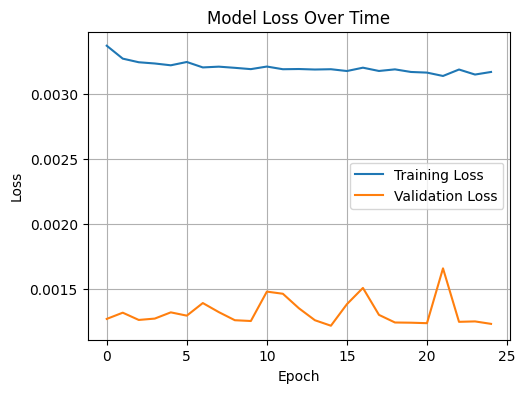

In [423]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

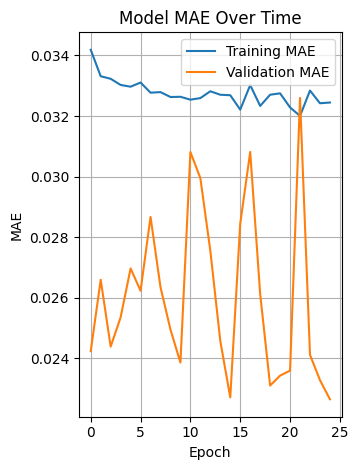

In [424]:
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE Over Time')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [425]:
# Evaluate Model & Predictions
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Make predictions
predictions = model.predict(X_test)

# Inverse transform predictions and actual values
predicted_values = scaler.inverse_transform(predictions)
actual_values = scaler.inverse_transform(y_test.reshape(-1, 1))

# Model Evaluation
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_values, predicted_values)
r2 = r2_score(actual_values, predicted_values)

print("\nModel Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

Model Performance Metrics:
Mean Squared Error (MSE): 1234.7572
Root Mean Squared Error (RMSE): 35.1391
Mean Absolute Error (MAE): 14.5310
R-squared (R2): 0.0269


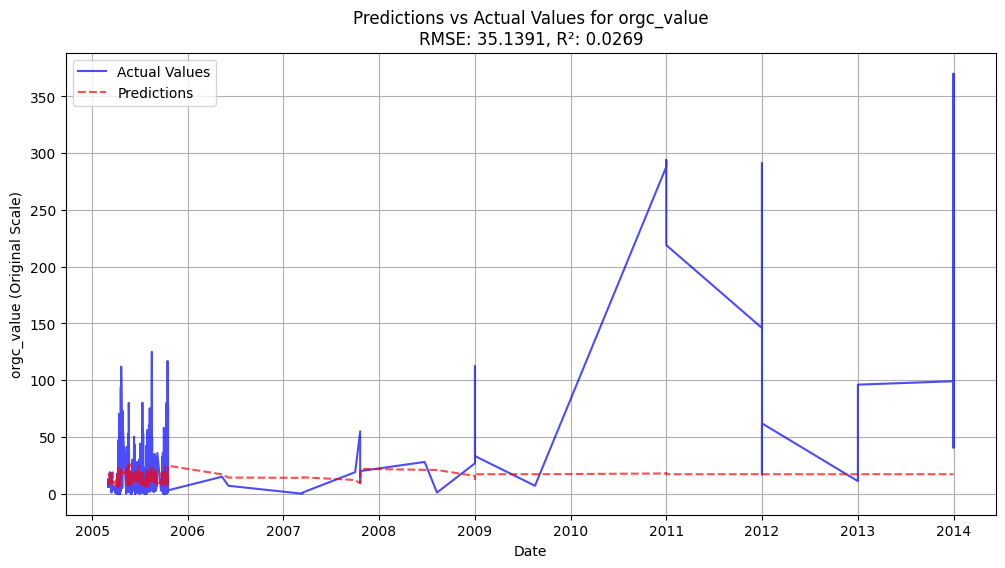

In [426]:
# Plot Predictions vs Actual
plt.figure(figsize=(12, 6))
plt.plot(df_test.index[n_length:], actual_values, label="Actual Values", color="blue", alpha=0.7)
plt.plot(df_test.index[n_length:], predicted_values, label="Predictions", color="red", linestyle="--", alpha=0.7)
plt.xlabel("Date")
plt.ylabel(f"{target_column} (Original Scale)")
plt.title(f"Predictions vs Actual Values for {target_column}\nRMSE: {rmse:.4f}, R²: {r2:.4f}")
plt.legend()
plt.grid(True)
plt.show()